In [1]:
# %%
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


c:\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:


# %%
# make a transform to normalize the data and change dtype to float tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


<Figure size 72x1872 with 0 Axes>

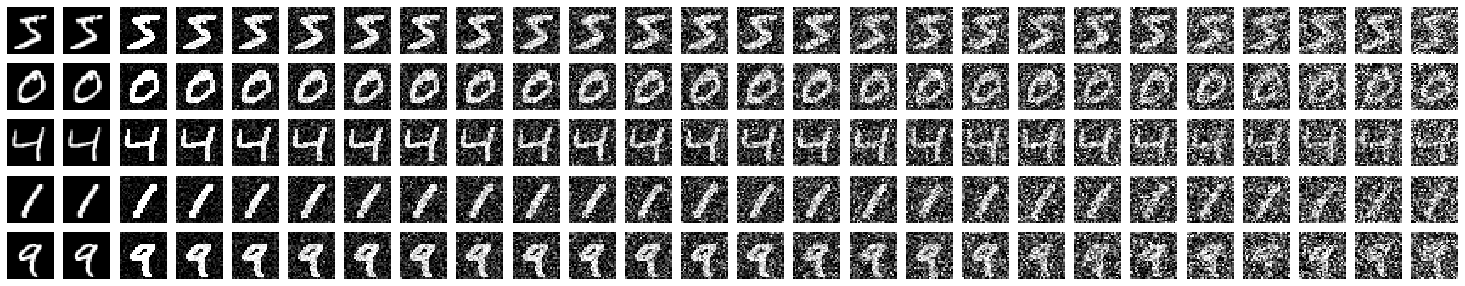

<Figure size 72x1872 with 0 Axes>

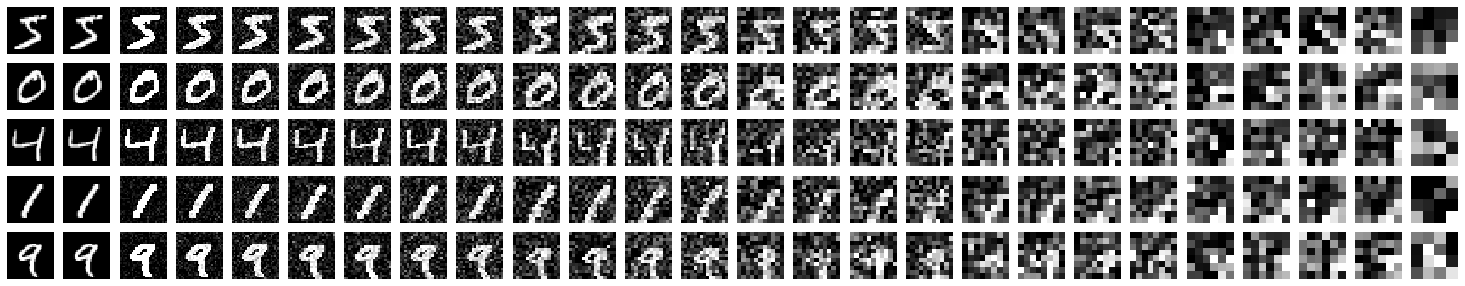

In [3]:
def degrade_to_t(img : torch.tensor, t : int, stage_length : int) -> torch.tensor: 
    
    img = img.clone()

    for i in range(t[0]):
        # generate noise in the same shape as the image
        noise = torch.randn_like(img)

        # add noise to the image, scale it
        noised = img + noise * 0.1

        # downscale the image every stagelength'th step
        if i % stage_length == stage_length-1:
            img = torch.nn.functional.interpolate(img, scale_factor=0.75, mode="nearest")
        else:
            img = noised

        # clip the image to be between 0 and 1
        img = torch.clamp(img, 0, 1)
        
    return img


def noise_scale(t, stages) -> float:
    # scale the noise as a function of time
    return 4 * (1 - t / stages)

def plot_forward_degradation(stages : int = 10, stageLength : int = 4):
    ts = range(stages)

    batch_size = 5
    img = train_dataset.data[0:batch_size].float().unsqueeze(1)
    all = [img]
    for t in ts:
        all.append(        
            degrade_to_t(img, torch.tensor([t]), stageLength)
        )

    # take all the images and plot them side by side
    plt.figure(figsize=(1, len(ts)))
    fig, rows = plt.subplots(batch_size, len(ts), figsize=(len(ts), batch_size))
    for t, row in enumerate(rows):
        for b, ax in enumerate(row):
            ax.axis('off')
            ax.imshow(all[b][t].squeeze(), cmap="gray", aspect='auto', interpolation='nearest')

plot_forward_degradation(stages=26, stageLength=26)
plot_forward_degradation(stages=26, stageLength=4)

<Figure size 72x1440 with 0 Axes>

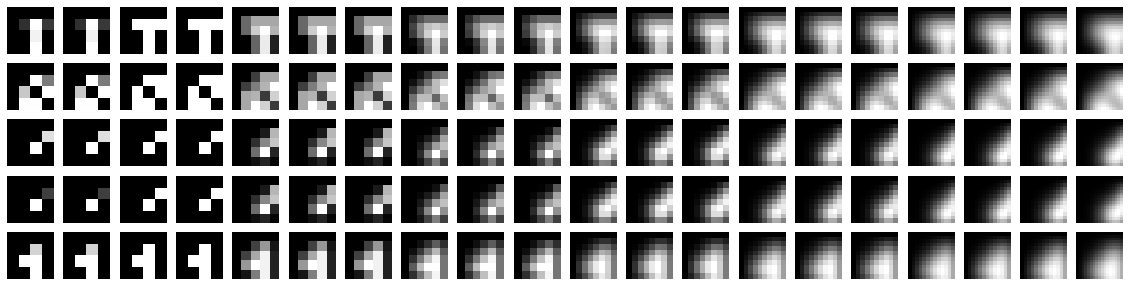

In [4]:
def restore_to_t(img : torch.tensor, scale_func, t : int, stage_length : int) -> torch.tensor: 
    
    img = img.clone()

    for i in range(t[0]):
        # generate noise in the same shape as the image
        noise = torch.randn_like(img)

        # add noise to the image, scale it
        noised = img #+ noise * scale_func(torch.tensor(i), stage_length)

        # downscale the image every stagelength'th step
        if i % stage_length == stage_length-1:
            img = img = torch.nn.functional.interpolate(img, scale_factor=1/0.75, mode="bilinear")
        else:
            img = noised

        # clip the image to be between 0 and 1
        img = torch.clamp(img, 0, 1)
        
    return img

def plot_backward_restoration(stages : int = 10, stageLength : int = 4):
    ts = range(stages)

    batch_size = 5
    img = torch.nn.functional.interpolate(train_dataset.data[0:batch_size].float().unsqueeze(1), size=(4,4), mode="nearest")
    all = [img]
    for t in ts:
        all.append(        
            restore_to_t(img, noise_scale, torch.tensor([t]), stageLength)
        )

    # take all the images and plot them side by side
    plt.figure(figsize=(1, len(ts)))
    fig, rows = plt.subplots(batch_size, len(ts), figsize=(len(ts), batch_size))
    for t, row in enumerate(rows):
        for b, ax in enumerate(row):
            ax.axis('off')
            ax.imshow(all[b][t].squeeze(), cmap="gray", aspect='auto', interpolation='nearest')

plot_backward_restoration(stages=20, stageLength=3)

In [5]:
import tqdm
# skeleton of training loop with multiscale denoising:

T = 10


# --- dummy model that predicts the degradation
var = torch.tensor(0.1)
var.requires_grad = True
def model(imgs : torch.tensor, t : torch.tensor) -> torch.tensor:
    # predict the degradation for the image at time t
    return torch.randn_like(imgs) + var
# --- 

optim = torch.optim.Adam([var], lr=0.001)

epochs = 2
for epoch in tqdm.tqdm(range(epochs)):
    for batch_idx, (imgs, _targets) in enumerate(train_loader):
        
        imgs = torch.tensor(imgs)
        
        # data is a batch of images
        # target is a batch of labels

        # sample a time step with batch size
        t = torch.randint(0, T, size=(imgs.shape[0],))

        # generate degradation in the same shape as the image
        degraded_img = degrade_to_t(imgs, noise_scale(t), t, 10)

        predicted_degredation = model(degraded_img, t)

        # compute loss
        loss = torch.nn.functional.mse_loss(degraded_img - predicted_degredation, imgs)
        loss.backward()

        optim.step()
        optim.zero_grad()

        print(loss)

    print("epoch", epoch)




  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Theo\AppData\Local\Temp\ipykernel_19952\3427690682.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs)
  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: noise_scale() missing 1 required positional argument: 'stages'